<center><h1><b><mark style="background-color: #ff1493; color: black;">IP CW Draft</mark></b></h1></center>


In this coursework, you will be asked to develop an image processing pipeline to separate flower material from background. This requires a processing pipeline that usually includes at least some of the following steps:

- <b>Colour space conversion</b>: choose a colour space. Any can be used, but most people choose to work in a lower-dimensional (<3) space whenever possible.

- <b>Noise reduction</b>: depending on image quality, some form of noise suppression may be required.

- <b>Thresholding/Segmentation</b>: image regions corresponding to nuclei must be identified, and thresholding is a common approach. The method used varies and may be global or local. Methods that automatically determine the threshold value  have obvious advantages over those that require user interaction. Binary image processing: Identifying a perfect threshold value or segmentation  method is almost impossible, and most methods will result in some mis-classified  pixels. A further binary image processing stage is often needed to clean up the image, hopefully leaving it containing only regions that correspond to plants.  Nothing, however, is perfect.

- <b>Dataset</b>: Images of three species of flowers are collected in a folder available from  Moodle. The images are selected based on the complexity of their foreground/background features and categorised into three sub-folders (e.g., easy, medium, and hard) within the input-image folder. To aid with analysing the effectiveness of your solution, ground truth for each image is provided within the  ground-truth folder, again categorised within three sub-folders (e.g., easy, medium, and hard).

https://www.researchgate.net/publication/286225842_Flower_recognition_system_based_on_image_processing


- make bg dark as possible - background flowers also should become darker
- center of flower should become lighter, including shadows on inner of flower

Functions List:
- convert to black and white
- convert image using binary thresholding
- negation
- contrast stretching
- gain
- bias
- guassian filtering
- 

In [115]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def convert_BW(img):
    
    # converts the image to grayscale
    
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_bw
    
def binary_threshold(img, threshold_num, max_num):
    
    # threshold_num -> the number which decides whether the pixel should be black or white
    # max_num -> highest gray value, eg. 255
    
    _, bi_image = cv2.threshold(img, threshold_num, max_num, cv2.THRESH_BINARY)
    return bi_image

def contrast_stretch(img, min_num, max_num): 
    
    # adjusts the image to the new minimum and maximum values
    # min_num -> lowest gray value, eg. 0
    # max_num -> highest gray value, eg. 255
    
    contrast_img = cv2.normalize(img, None, min_num, max_num, norm_type=cv2.NORM_MINMAX)
    return contrast_img

# def negation(img):
     
#     # img -> the image to negate
    
#     negated_image = 255 - img
#     return negated_image

def negation(img):
    # Ensure the image is in uint8 format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    negated_image = 255 - img
    return negated_image

def median_blur(img,kernel_size):
    
    # kernel_size -> size of kernel, like 3x3? 5x5?
    
    blurred_image = cv2.medianBlur(img, kernel_size)
    return blurred_image

def inc_gain(img,gain_factor):
    
    # gain_factor -> by how much increase for gain?
    
    scaled_image = img * gain_factor
    scaled_image[scaled_image > 255] = 255
    return scaled_image
    
def inc_bias(img, bias_value):
    biased_image = img + bias_value
    biased_image[biased_image > 255] = 255
    return biased_image

def histogramEq(img):
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    equalise = cv2.equalizeHist(img)
    return equalise

def otsu_Thresholding(img):
    _, otsu_threshold = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_threshold

def edge_Detect(img):
    edges = cv2.Canny(img, threshold1=50, threshold2=100)
    return edges

def gamma_Correction(img, g):
    gamma = g
    gamma_img = ((img / 255) ** gamma) * 255
    gamma_img = gamma_img.astype("uint8")
    return gamma_img

def morphology_close(image,kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closing_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing_image

def morphology_open(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening_image


def calculate_miou(ground_truth, final):
    print(ground_truth.shape)
    print(final.shape)
        
    # Compute SSIM between two images
    similarity = ssim(ground_truth, final)
    return similarity

def roi_remove_white(image):
    #applying ROI:
    _, mask = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.bitwise_not(mask)
    roi_img = cv2.bitwise_and(image, image, mask=mask)
    return roi_img
    
def extract_foreground(image):    
    height, width = image.shape[:2]
    mask = np.zeros(image.shape[:2], np.uint8)
    rectangle = (10, 10, width, height)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    cv2.grabCut(image, mask, rectangle, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    foreground_mask = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(image, image, mask=foreground_mask)
    return foreground



# customizable function to apply all processing functions to image
def image_pipeline(img,ground):
    
    _, ground_t = cv2.threshold(convert_BW(ground), 50, 255, cv2.THRESH_BINARY)
    
    bw_img = convert_BW(img)
    
#     blur_img=median_blur(bw_img,21)
    
    blur_img=median_blur(bw_img,21)
    
    g_img= gamma_Correction(blur_img,3.5)

    gain_img = inc_gain(g_img,0.5)
    
    negated_img = negation(gain_img)
    
    g_img2 = gamma_Correction(negated_img,6.0)
    
#     hist_eq_img = histogramEq(g_img2)
#APPLY HISTOGRAM EQUALISATION ON THE ROI IMAGE

    _, bi_thresh_img = cv2.threshold(g_img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    morph_close_img = morphology_close(bi_thresh_img,7)
    morph_open_img = morphology_open(morph_close_img,7)
    
    final_img = morph_open_img    
    
    foreground_img = extract_foreground(g_img)
    
    
#     bias = inc_bias(g_img2,-50)
    
    print("similarity: ",calculate_miou(final_img,ground_t))

    # display half-processed images
    
    fig, (bw,blur,gamma1,gain) = plt.subplots(1, 4, figsize=(17, 9))
    bw.imshow(bw_img, cmap="gray")
    bw.set_title("bw")
    blur.imshow(blur_img, cmap="gray")
    blur.set_title("blur")
    gamma1.imshow(g_img, cmap="gray")
    gamma1.set_title("gamma")
    gain.imshow(gain_img, cmap="gray")
    gain.set_title("gain")
    
    fig, (negate,gamma2,bi_threshold,fground) = plt.subplots(1, 4, figsize=(14, 9))
    negate.imshow(negated_img, cmap="gray")
    negate.set_title("negated")
    gamma2.imshow(g_img2, cmap="gray")
    gamma2.set_title("gamma2")
    fground.imshow(foreground_img, cmap="gray")
    fground.set_title("fground")
    bi_threshold.imshow(bi_thresh_img, cmap="gray")
    bi_threshold.set_title("binary threshold")
    
    fig, (morph_close,morph_open,final,ground) = plt.subplots(1, 4, figsize=(14, 9))
    morph_close.imshow(morph_close_img, cmap="gray")
    morph_close.set_title("morph close")
    morph_open.imshow(morph_open_img, cmap="gray")
    morph_open.set_title("morph open")
    final.imshow(final_img, cmap="gray")
    final.set_title("final") 
    ground.imshow(ground_t, cmap="gray")
    ground.set_title("ground_t") 
    
    plt.tight_layout()
    plt.show()
    return final



In [109]:
def display_pipeline(image_pipeline):
    
    # image_pipeline -> name of your image_pipeline function, which will be applied to all images in dataset and displayed
    
    file_names = ["easy","medium","hard"]
    
    # getting all images file directories
    # C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\input_images\\easy\\easy_1.jpg
    
#     input_file_directory = "C:\\Users\\ansha\\OneDrive - University of Nottingham Malaysia\\Uni\\ImageProcessing\\Dataset\\Dataset\\input_images\\"
#     ground_truth_directory =  "C:\\Users\\ansha\\OneDrive - University of Nottingham Malaysia\\Uni\\ImageProcessing\\Dataset\\Dataset\\ground_truths\\"
    input_file_directory = '.\\Dataset\\Dataset\\input_images\\'
    ground_truth_directory =  '.\\Dataset\\Dataset\\ground_truths\\'
    
    for j in file_names:
        
        first_file_directory = input_file_directory+j+"\\"+j+"_"+"1"+".jpg"
        sec_file_directory = input_file_directory+j+"\\"+j+"_"+"2"+".jpg"
        third_file_directory = input_file_directory+j+"\\"+j+"_"+"3"+".jpg"
        
        ground1=ground_truth_directory+j+"\\"+j+"_"+"1"+".png"
        ground2=ground_truth_directory+j+"\\"+j+"_"+"2"+".png"
        ground3=ground_truth_directory+j+"\\"+j+"_"+"3"+".png"

        # getting input images
        image1=cv2.imread(first_file_directory, cv2.IMREAD_COLOR)
        image2=cv2.imread(sec_file_directory, cv2.IMREAD_COLOR)
        image3=cv2.imread(third_file_directory, cv2.IMREAD_COLOR)

        
        # getting all processed images
        gimage1=cv2.imread(ground1, cv2.IMREAD_COLOR)
        gimage2=cv2.imread(ground2, cv2.IMREAD_COLOR)
        gimage3=cv2.imread(ground3, cv2.IMREAD_COLOR)
        
        # getting final images
        fimage1=image_pipeline(image1,gimage1)
        fimage2=image_pipeline(image2,gimage2)
        fimage3=image_pipeline(image3,gimage3)

(500, 666)
(500, 666)
similarity:  0.84247715537698


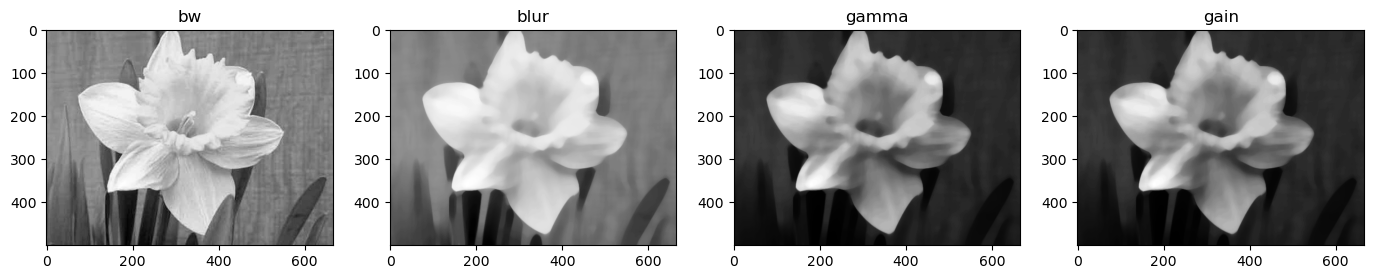

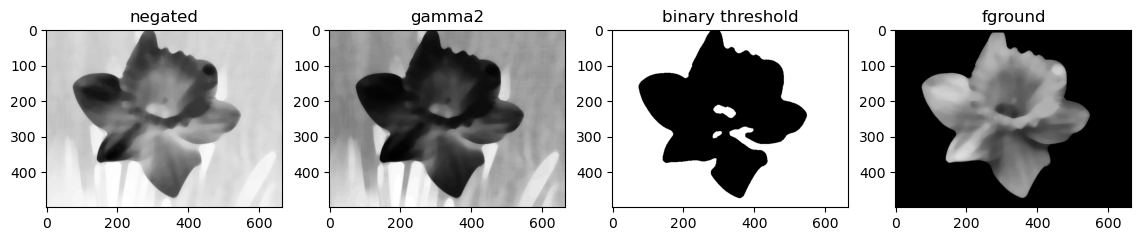

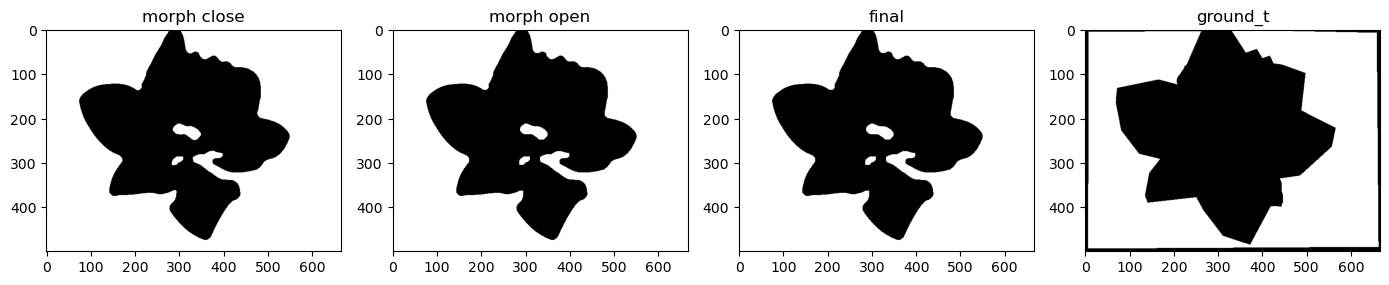

(500, 666)
(500, 666)
similarity:  0.8455841269393087


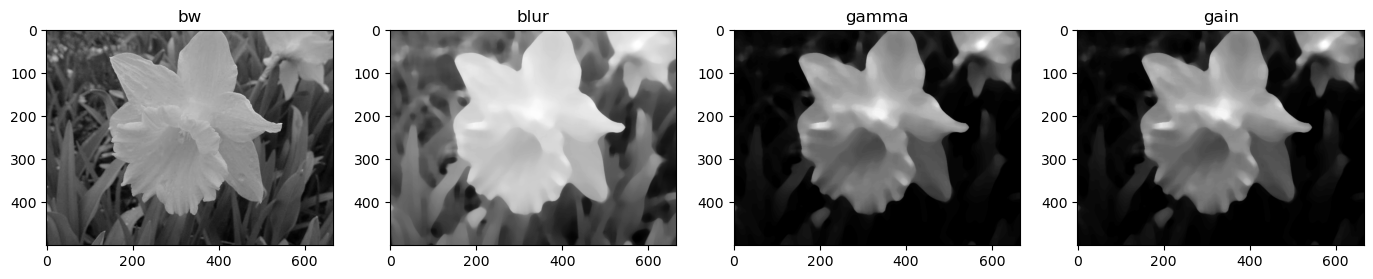

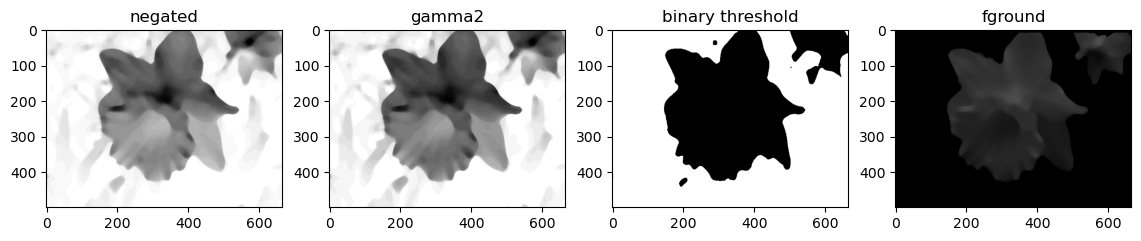

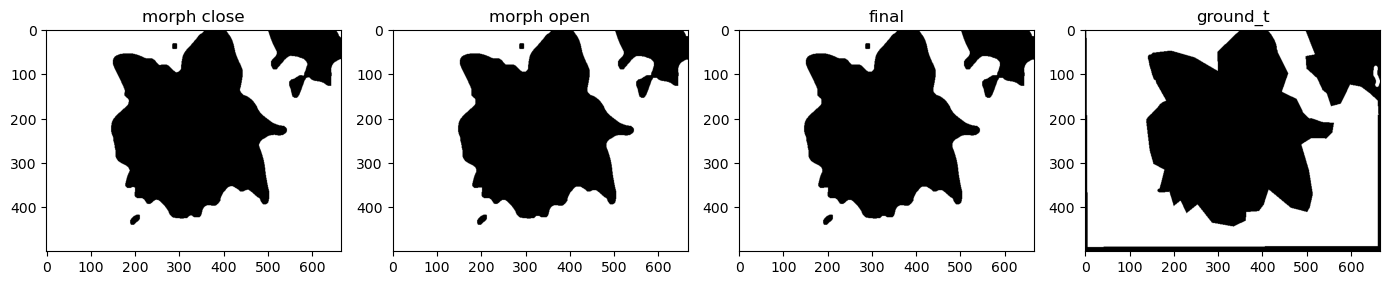

(500, 666)
(500, 666)
similarity:  0.8830060064771323


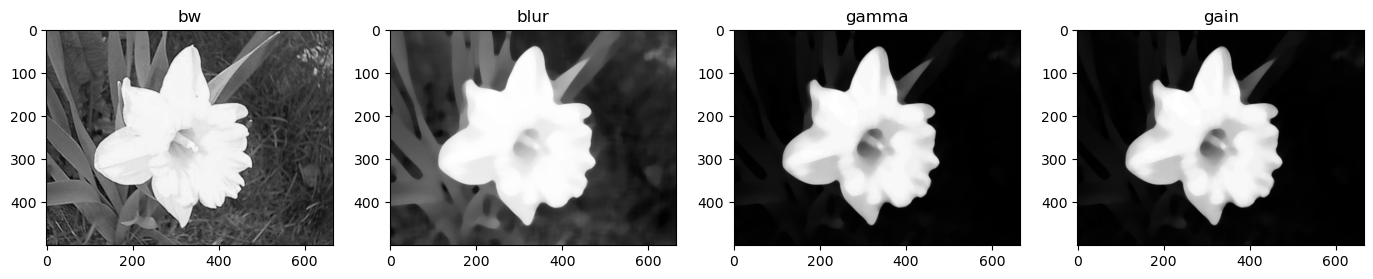

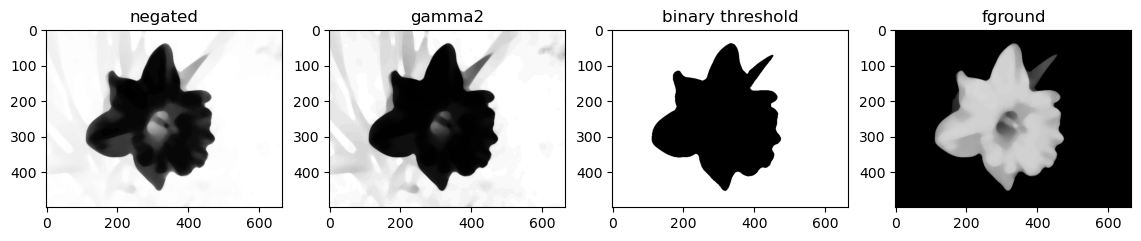

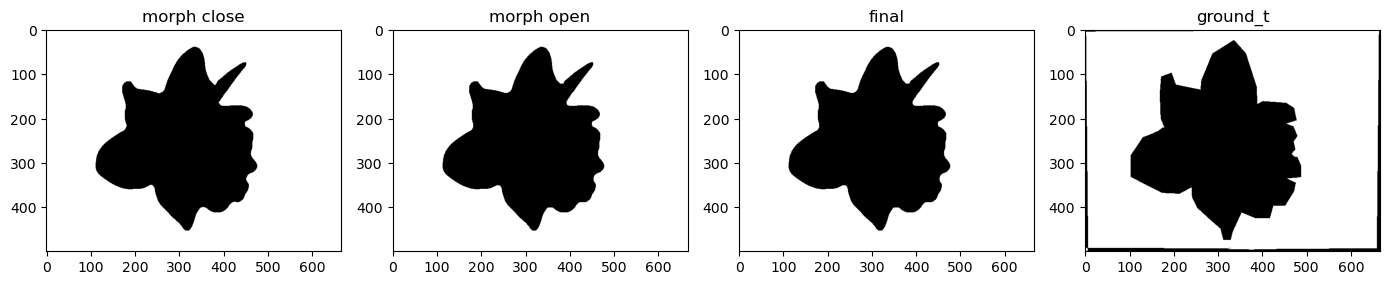

(529, 500)
(529, 500)
similarity:  0.6711092206799846


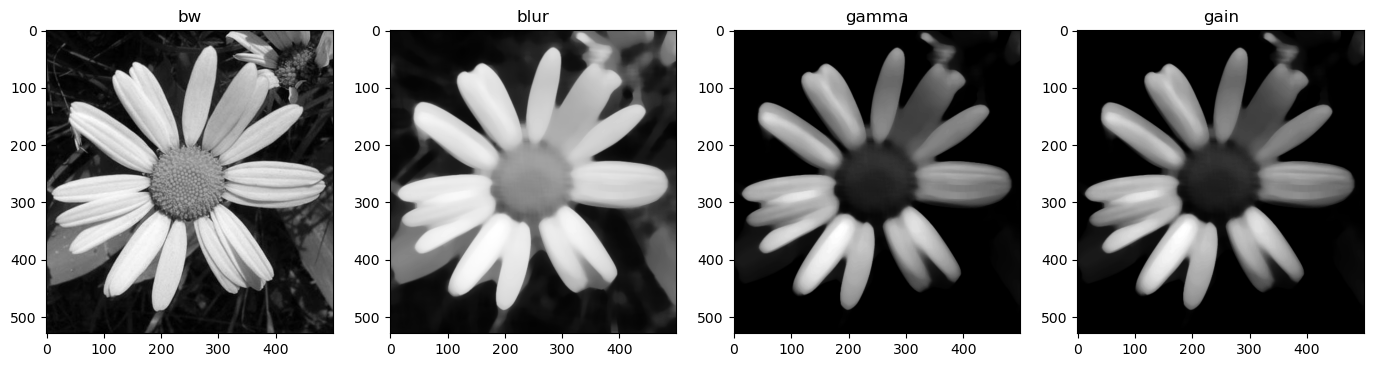

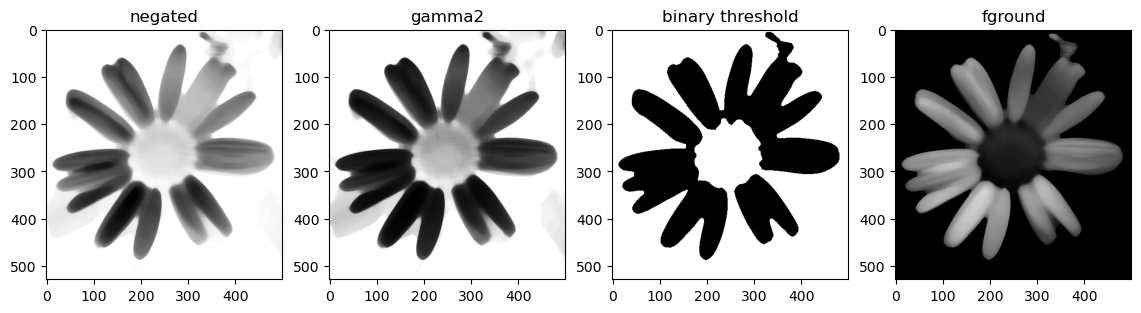

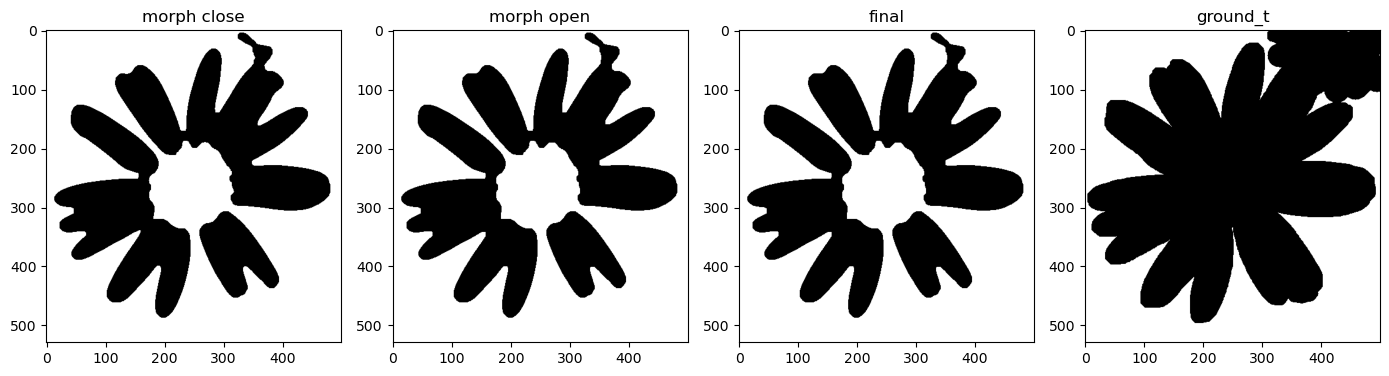

(500, 750)
(500, 750)
similarity:  0.8334212120334449


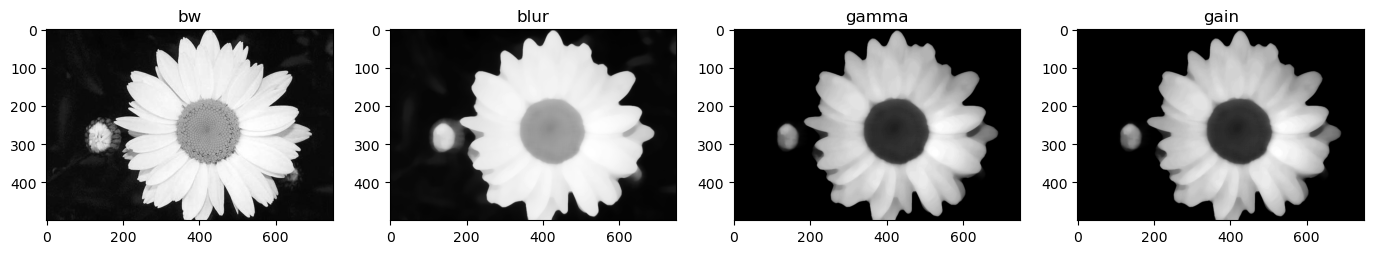

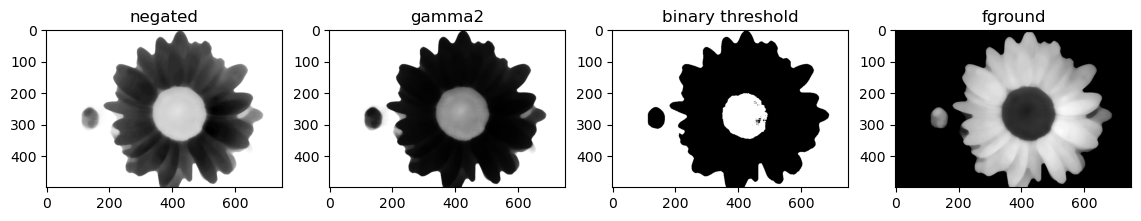

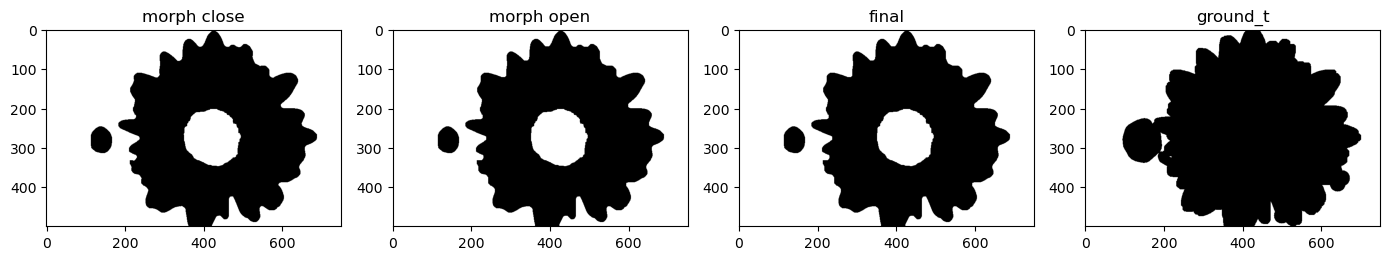

(500, 538)
(500, 538)
similarity:  0.7743967463727023


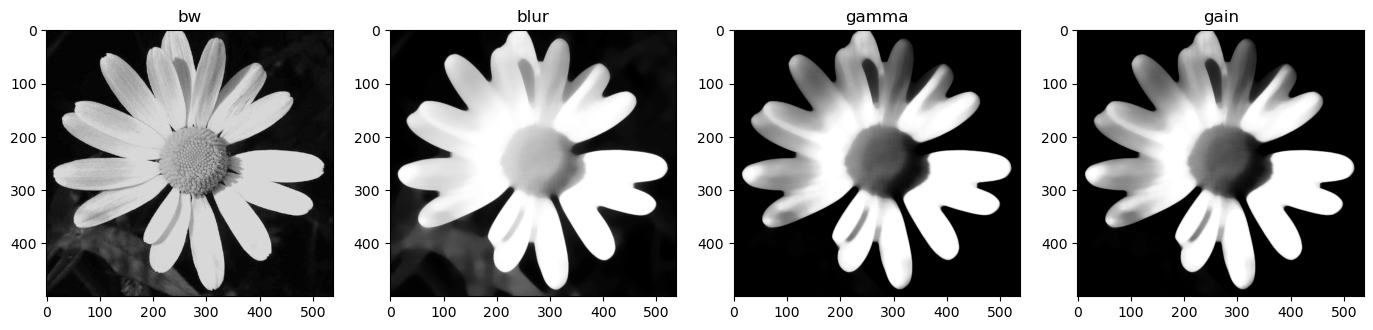

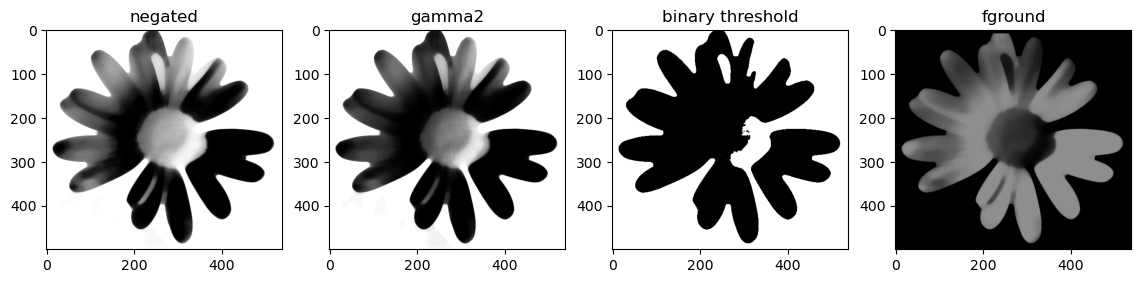

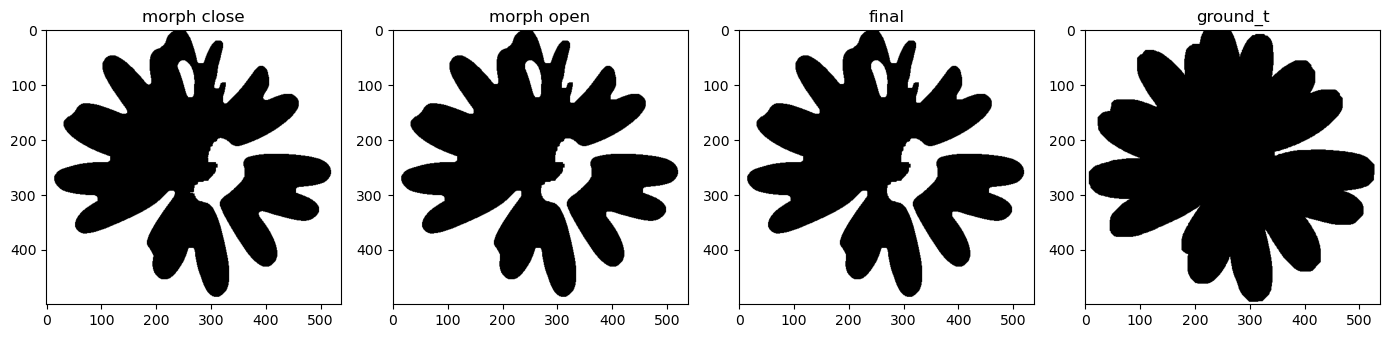

(500, 518)
(500, 518)
similarity:  0.8570215827812904


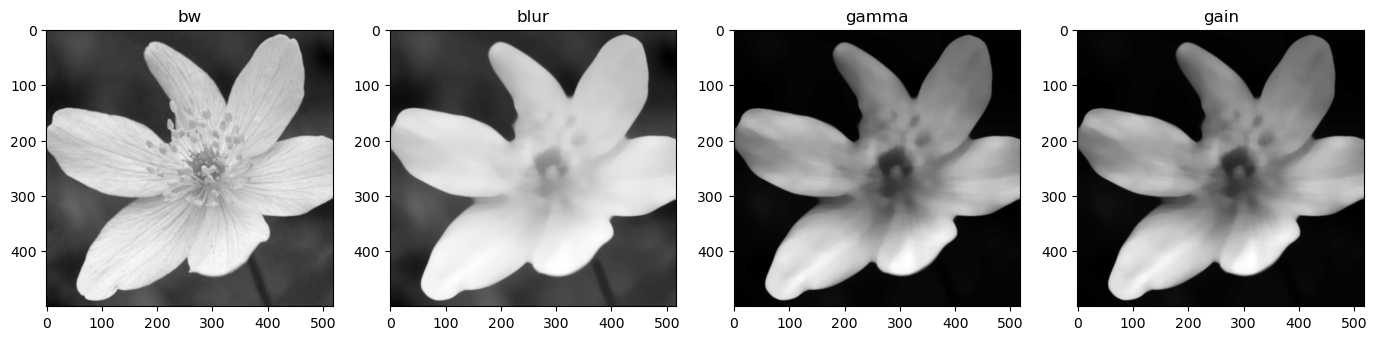

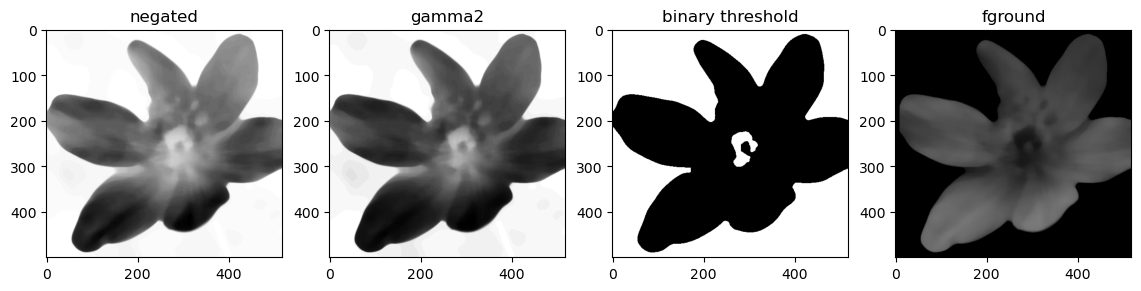

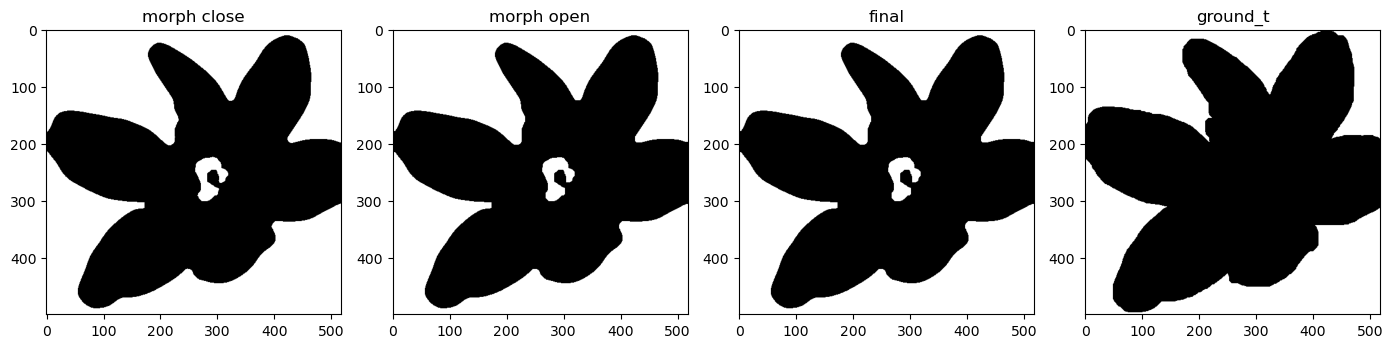

(500, 600)
(500, 600)
similarity:  0.7632024957490005


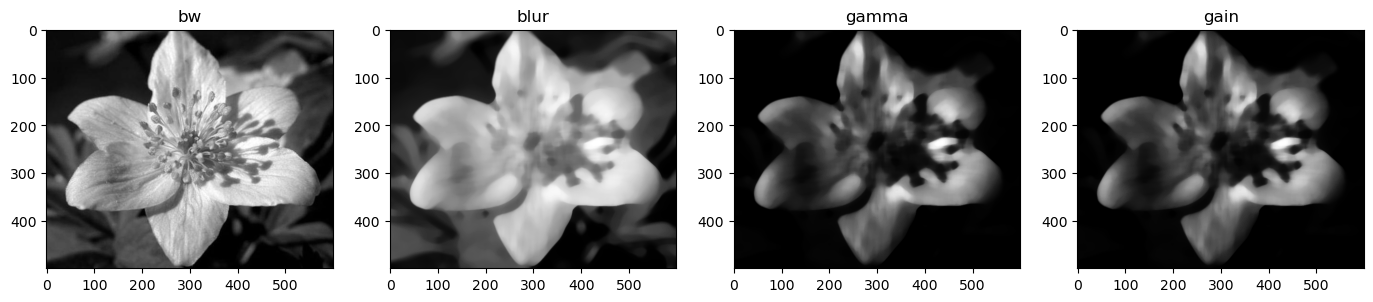

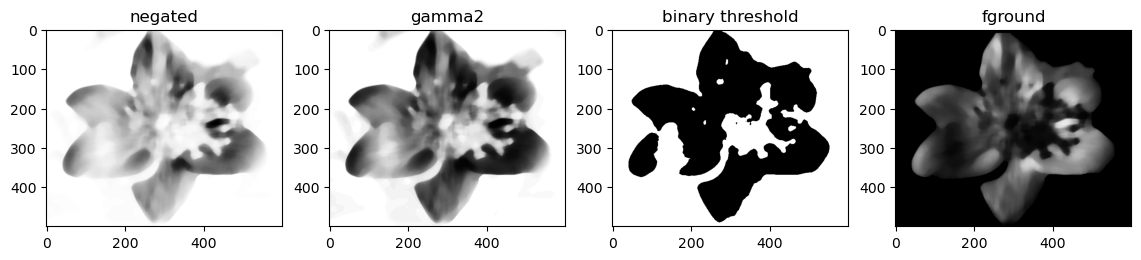

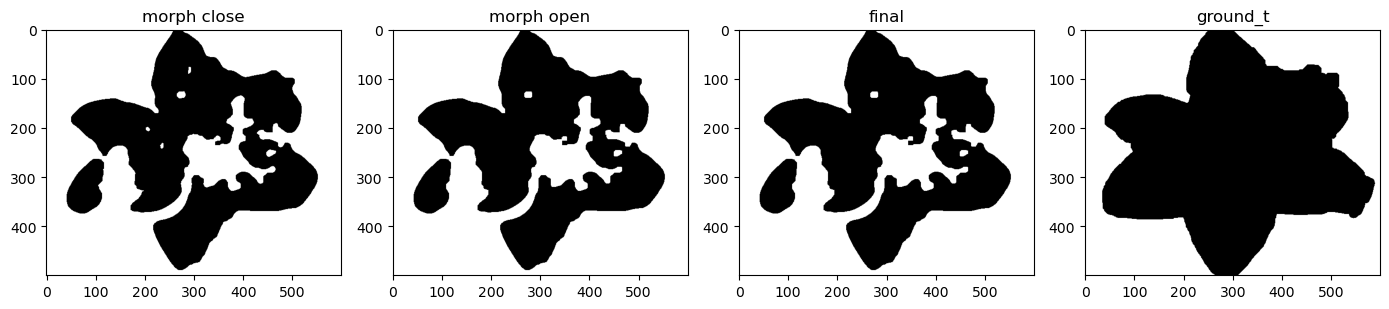

(500, 500)
(500, 500)
similarity:  0.8659852767433479


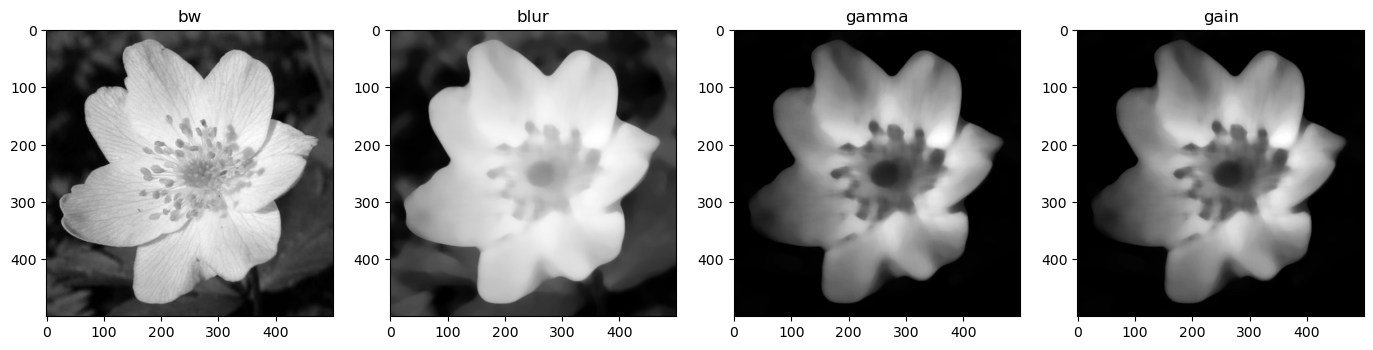

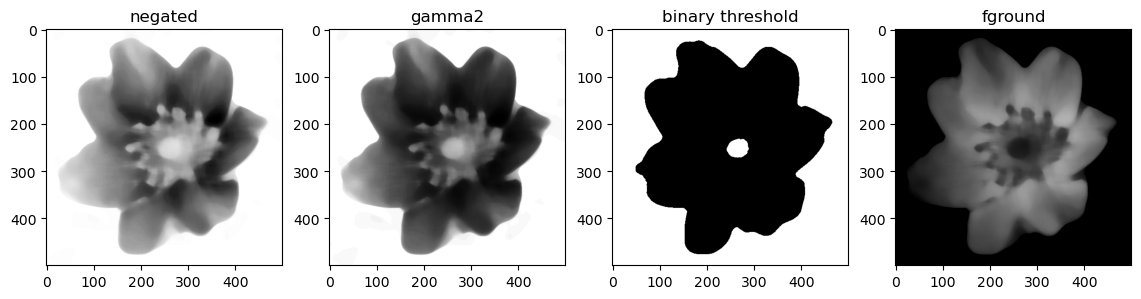

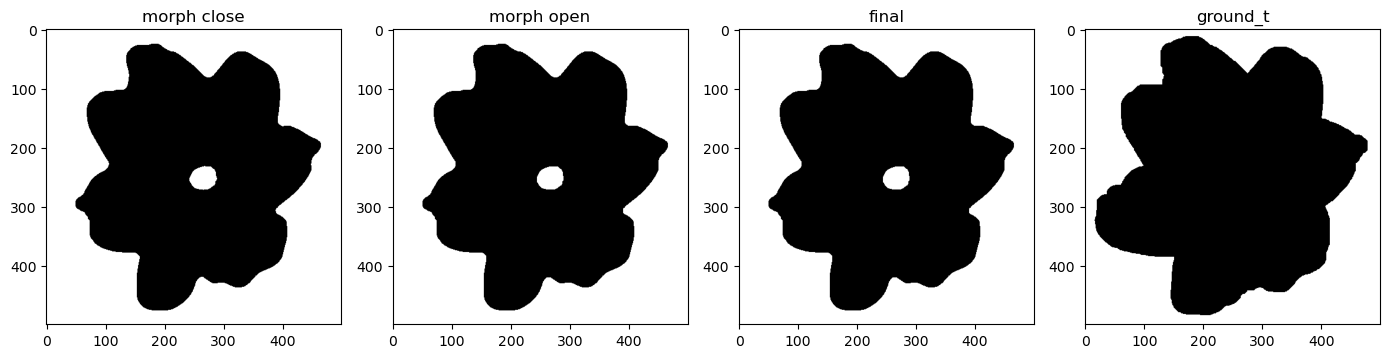

In [116]:
display_pipeline(image_pipeline)